In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn
import joblib
import os
import warnings

warnings.filterwarnings('ignore')
print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Prepare Data

In [2]:
# Load cleaned data
df = pd.read_csv('../data/processed/heart_cleaned.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1,1,145.0,233.0,1,2,150.0,0,2.3,3,0,6,0
1,67.0,1,4,160.0,286.0,0,2,108.0,1,1.5,2,3,3,1
2,67.0,1,4,120.0,229.0,0,2,129.0,1,2.6,2,2,7,1
3,37.0,1,3,130.0,250.0,0,0,187.0,0,3.5,3,0,3,0
4,41.0,0,2,130.0,204.0,0,2,172.0,0,1.4,1,0,3,0


In [3]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())

Features shape: (303, 13)
Target shape: (303,)

Target distribution:
target
0    164
1    139
Name: count, dtype: int64


In [4]:
# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 242 samples
Test set: 61 samples


In [5]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for later use
os.makedirs('../models', exist_ok=True)
joblib.dump(scaler, '../models/scaler.joblib')
print("✓ Scaler fitted and saved")

✓ Scaler fitted and saved


## 2. Setup MLflow Experiment Tracking

In [6]:
# Set up MLflow
mlflow.set_tracking_uri("file:../mlruns")
experiment_name = "heart-disease-classification"

# Create or get experiment
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    experiment_id = experiment.experiment_id

mlflow.set_experiment(experiment_name)
print(f"MLflow experiment: {experiment_name}")
print(f"Experiment ID: {experiment_id}")

MLflow experiment: heart-disease-classification
Experiment ID: 767575073053142380


In [10]:
# Helper function to evaluate and log model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate model and return metrics."""
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1_score': f1_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_proba)
    }
    
    # Print results
    print(f"\n{'='*50}")
    print(f"Model: {model_name}")
    print(f"{'='*50}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_test_pred))
    
    return metrics, y_test_pred, y_test_proba


def plot_confusion_matrix(y_test, y_pred, model_name):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    
    # Save plot
    os.makedirs('../screenshots', exist_ok=True)
    plt.savefig(f'../screenshots/confusion_matrix_{model_name.lower().replace(" ", "_")}.png', dpi=150)
    plt.show()
    
    return cm


def plot_roc_curve(y_test, y_proba, model_name):
    """Plot ROC curve."""
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='#3498db', lw=2, label=f'{model_name} (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.savefig(f'../screenshots/roc_curve_{model_name.lower().replace(" ", "_")}.png', dpi=150)
    plt.show()
    
    return fpr, tpr, auc

## 3. Model 1: Logistic Regression

2025/12/14 20:03:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Cross-validation scores: [0.91836735 0.7755102  0.83333333 0.83333333 0.77083333]
Mean CV Accuracy: 0.8263 (+/- 0.1067)

Model: Logistic Regression
train_accuracy: 0.8512
test_accuracy: 0.8689
precision: 0.8125
recall: 0.9286
f1_score: 0.8667
roc_auc: 0.9513

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



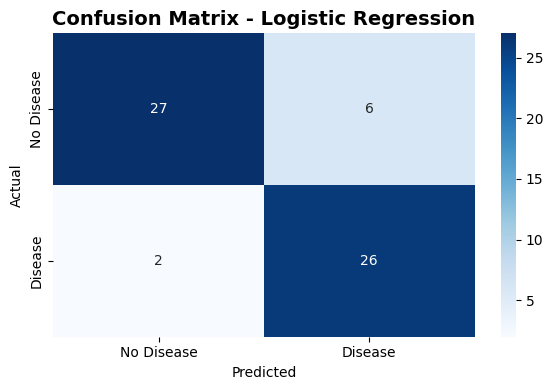

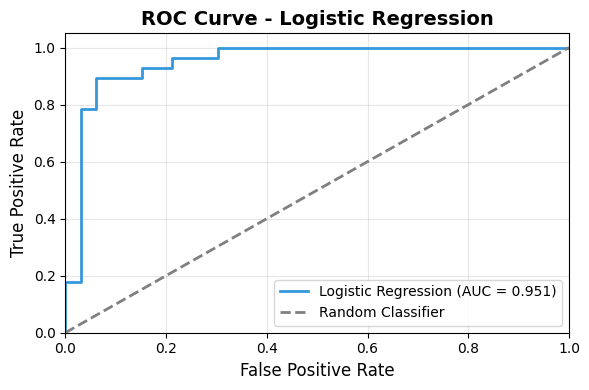


✓ Logistic Regression run logged to MLflow


In [11]:
# Logistic Regression with MLflow tracking
with mlflow.start_run(run_name="Logistic_Regression"):
    # Hyperparameters
    params = {
        'C': 1.0,
        'penalty': 'l2',
        'solver': 'lbfgs',
        'max_iter': 1000,
        'random_state': 42
    }
    
    # Log parameters
    mlflow.log_params(params)
    
    # Train model
    lr_model = LogisticRegression(**params)
    lr_model.fit(X_train_scaled, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    
    # Evaluate
    metrics, y_pred_lr, y_proba_lr = evaluate_model(
        lr_model, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression"
    )
    
    # Log metrics
    mlflow.log_metrics(metrics)
    mlflow.log_metric("cv_mean_accuracy", cv_scores.mean())
    mlflow.log_metric("cv_std", cv_scores.std())
    
    # Log model
    mlflow.sklearn.log_model(lr_model, "logistic_regression_model")
    
    # Plot and save artifacts
    plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")
    plot_roc_curve(y_test, y_proba_lr, "Logistic Regression")
    
    mlflow.log_artifact('../screenshots/confusion_matrix_logistic_regression.png')
    mlflow.log_artifact('../screenshots/roc_curve_logistic_regression.png')
    
    print("\n✓ Logistic Regression run logged to MLflow")

## 4. Model 2: Random Forest Classifier

2025/12/14 20:20:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Cross-validation scores: [0.87755102 0.7755102  0.8125     0.75       0.79166667]
Mean CV Accuracy: 0.8014 (+/- 0.0864)

Model: Random Forest
train_accuracy: 0.9711
test_accuracy: 0.8852
precision: 0.8387
recall: 0.9286
f1_score: 0.8814
roc_auc: 0.9502

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89        33
           1       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



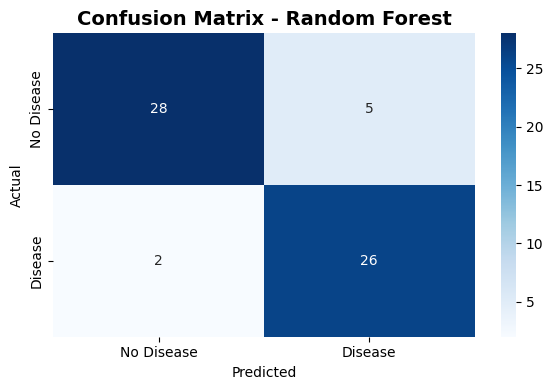

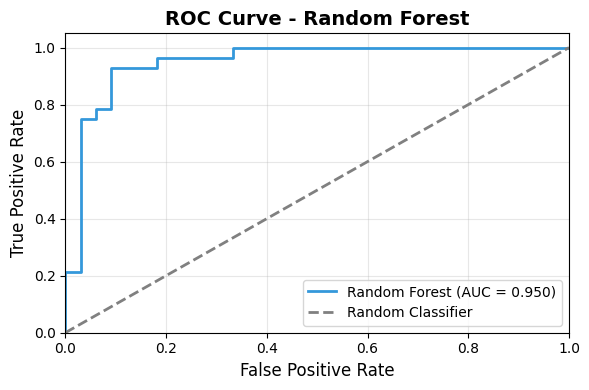


✓ Random Forest run logged to MLflow


In [12]:
# Random Forest with Hyperparameter Tuning and MLflow tracking
with mlflow.start_run(run_name="Random_Forest"):
    # Base parameters
    params = {
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Log parameters
    mlflow.log_params(params)
    
    # Train model
    rf_model = RandomForestClassifier(**params)
    rf_model.fit(X_train_scaled, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    
    # Evaluate
    metrics, y_pred_rf, y_proba_rf = evaluate_model(
        rf_model, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest"
    )
    
    # Log metrics
    mlflow.log_metrics(metrics)
    mlflow.log_metric("cv_mean_accuracy", cv_scores.mean())
    mlflow.log_metric("cv_std", cv_scores.std())
    
    # Log model
    mlflow.sklearn.log_model(rf_model, "random_forest_model")
    
    # Plot and save artifacts
    plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
    plot_roc_curve(y_test, y_proba_rf, "Random Forest")
    
    mlflow.log_artifact('../screenshots/confusion_matrix_random_forest.png')
    mlflow.log_artifact('../screenshots/roc_curve_random_forest.png')
    
    print("\n✓ Random Forest run logged to MLflow")

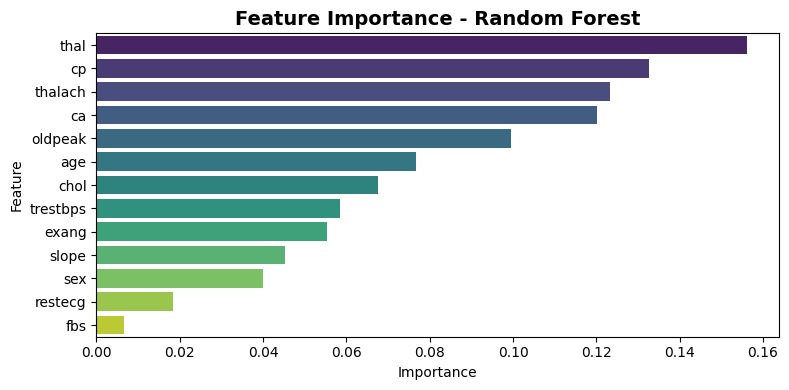


Top 5 Important Features:
    feature  importance
12     thal    0.156102
2        cp    0.132607
7   thalach    0.123178
11       ca    0.120167
9   oldpeak    0.099517


In [13]:
# Feature Importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('../screenshots/feature_importance.png', dpi=150)
plt.show()

print("\nTop 5 Important Features:")
print(feature_importance.head())

## 5. Model 3: Gradient Boosting

2025/12/15 00:18:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Cross-validation scores: [0.85714286 0.7755102  0.79166667 0.72916667 0.77083333]
Mean CV Accuracy: 0.7849 (+/- 0.0832)

Model: Gradient Boosting
train_accuracy: 1.0000
test_accuracy: 0.8525
precision: 0.7879
recall: 0.9286
f1_score: 0.8525
roc_auc: 0.9351

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.79      0.85        33
           1       0.79      0.93      0.85        28

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



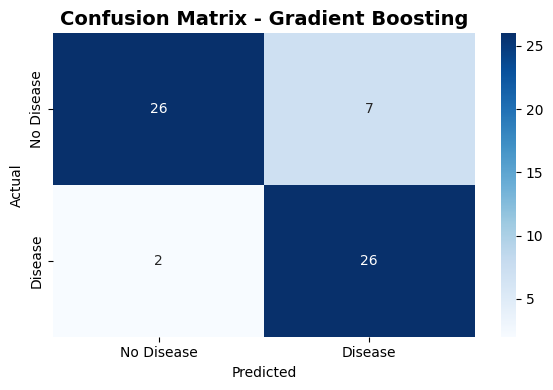

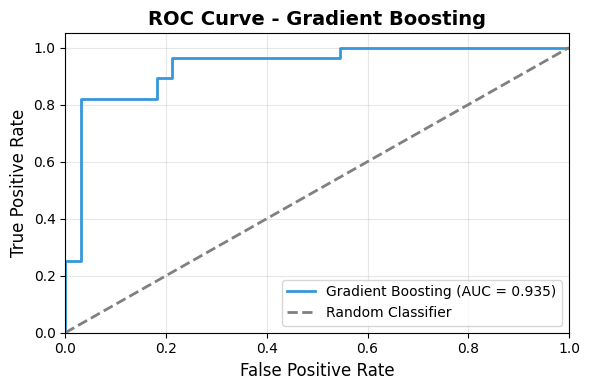


✓ Gradient Boosting run logged to MLflow


In [14]:
# Gradient Boosting with MLflow tracking
with mlflow.start_run(run_name="Gradient_Boosting"):
    # Parameters
    params = {
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': 5,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'random_state': 42
    }
    
    # Log parameters
    mlflow.log_params(params)
    
    # Train model
    gb_model = GradientBoostingClassifier(**params)
    gb_model.fit(X_train_scaled, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(gb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    
    # Evaluate
    metrics, y_pred_gb, y_proba_gb = evaluate_model(
        gb_model, X_train_scaled, X_test_scaled, y_train, y_test, "Gradient Boosting"
    )
    
    # Log metrics
    mlflow.log_metrics(metrics)
    mlflow.log_metric("cv_mean_accuracy", cv_scores.mean())
    mlflow.log_metric("cv_std", cv_scores.std())
    
    # Log model
    mlflow.sklearn.log_model(gb_model, "gradient_boosting_model")
    
    # Plot and save artifacts
    plot_confusion_matrix(y_test, y_pred_gb, "Gradient Boosting")
    plot_roc_curve(y_test, y_proba_gb, "Gradient Boosting")
    
    mlflow.log_artifact('../screenshots/confusion_matrix_gradient_boosting.png')
    mlflow.log_artifact('../screenshots/roc_curve_gradient_boosting.png')
    
    print("\n✓ Gradient Boosting run logged to MLflow")

## 6. Model Comparison

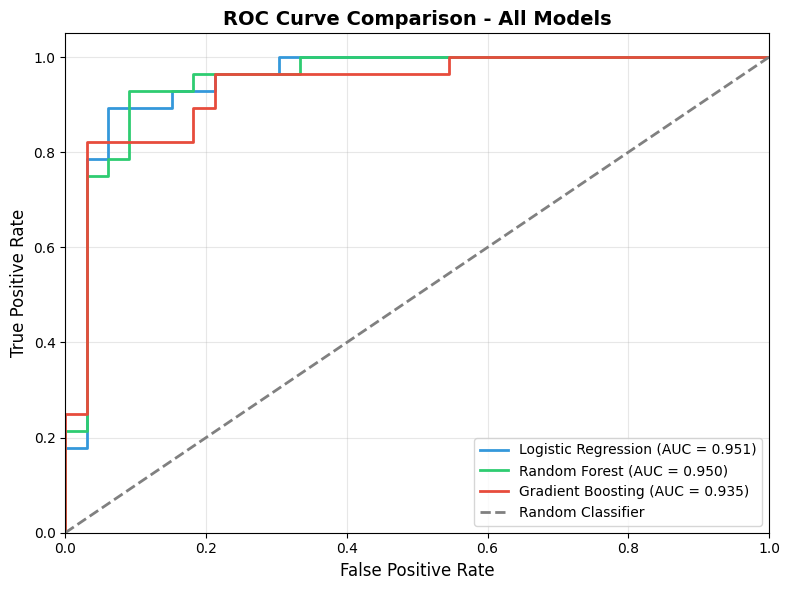

In [15]:
# Compare all models ROC curves
plt.figure(figsize=(8, 6))

models_data = [
    (y_proba_lr, 'Logistic Regression', '#3498db'),
    (y_proba_rf, 'Random Forest', '#2ecc71'),
    (y_proba_gb, 'Gradient Boosting', '#e74c3c')
]

for y_proba, name, color in models_data:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../screenshots/roc_comparison.png', dpi=150)
plt.show()

In [16]:
# Model Comparison Summary
comparison_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Test Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_gb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_gb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_gb)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_gb)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_gb)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Identify best model
best_model_idx = comparison_df['ROC-AUC'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\n🏆 Best Model (by ROC-AUC): {best_model_name}")


MODEL COMPARISON SUMMARY
              Model  Test Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression         0.8689     0.8125  0.9286    0.8667   0.9513
      Random Forest         0.8852     0.8387  0.9286    0.8814   0.9502
  Gradient Boosting         0.8525     0.7879  0.9286    0.8525   0.9351

🏆 Best Model (by ROC-AUC): Logistic Regression


## 7. Save Final Model

In [17]:
# Select best model 

best_model = lr_model  # Change this based on best performing model
best_model_name = "logistic_regression"

# Save the final model
joblib.dump(best_model, f'../models/best_model_{best_model_name}.joblib')
print(f"✓ Best model saved to '../models/best_model_{best_model_name}.joblib'")

# Save feature names for inference
feature_names = list(X.columns)
joblib.dump(feature_names, '../models/feature_names.joblib')
print("✓ Feature names saved to '../models/feature_names.joblib'")

✓ Best model saved to '../models/best_model_logistic_regression.joblib'
✓ Feature names saved to '../models/feature_names.joblib'


In [18]:
# Test model loading and inference
loaded_model = joblib.load(f'../models/best_model_{best_model_name}.joblib')
loaded_scaler = joblib.load('../models/scaler.joblib')

# Test prediction
sample = X_test.iloc[0:1]
sample_scaled = loaded_scaler.transform(sample)
prediction = loaded_model.predict(sample_scaled)
probability = loaded_model.predict_proba(sample_scaled)

print(f"\nTest Inference:")
print(f"Sample features: {sample.values[0]}")
print(f"Prediction: {'Heart Disease' if prediction[0] == 1 else 'No Heart Disease'}")
print(f"Probability: No Disease={probability[0][0]:.3f}, Disease={probability[0][1]:.3f}")
print(f"Actual: {'Heart Disease' if y_test.iloc[0] == 1 else 'No Heart Disease'}")


Test Inference:
Sample features: [ 59.   1.   4. 138. 271.   0.   2. 182.   0.   0.   1.   0.   3.]
Prediction: No Heart Disease
Probability: No Disease=0.782, Disease=0.218
Actual: No Heart Disease


In [19]:
# Print MLflow UI instructions
print("\n" + "="*60)
print("MLflow EXPERIMENT TRACKING")
print("="*60)
print("\nTo view experiments in MLflow UI, run:")
print("  cd heart-disease-mlops")
print("  mlflow ui --backend-store-uri file:mlruns")
print("\nThen open: http://localhost:5000")
print("="*60)


MLflow EXPERIMENT TRACKING

To view experiments in MLflow UI, run:
  cd heart-disease-mlops
  mlflow ui --backend-store-uri file:mlruns

Then open: http://localhost:5000
